Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [1]:
import numpy as np
from numpy.typing import NDArray

from gplearn.genetic import SymbolicRegressor
import graphviz
from IPython.display import display
import re
from typing import Any, Optional

import matplotlib.pyplot as plt

import os

PROBLEM_DIR: str = os.getcwd()
DATA_DIR: str = os.path.join(PROBLEM_DIR, "data")
os.makedirs(DATA_DIR, exist_ok=True)

In [ ]:
def train_test_split(
    X: NDArray[np.number[Any]],
    y: NDArray[np.number[Any]],
    test_size: float = 0.25,
    random_state: Optional[int] = 42,
    shuffle: bool = True,
) -> tuple[NDArray, NDArray, NDArray, NDArray]:
    """Split arrays or matrices into train and test subsets
    If shuffle is True, the function shuffles the data before splitting it,
    else the data is split in the order in which it is passed to the function.
    First n_train samples are used for training and the rest for testing.

    Args:
        X (NDArray[Any]): numpy array of shape (n_samples, n_features)
        y (NDArray[Any]): numpy array of shape (n_samples,)
        test_size (float, optional): Proportion of the original array X to be used for the test. Defaults to 0.25.
        random_state (Optional[int], optional): Seed to make the function deterministic. Defaults to 42.
        shuffle (bool, optional): Shuffle the indices to increase the entropy of the returned arrays. Defaults to True.

    Returns:
        tuple[NDArray, NDArray, NDArray, NDArray]: tuple of numpy arrays: (X_train, X_test, y_train, y_test)
    """
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(indices)
    n_test: int = int(len(indices) * test_size)
    n_train: int = len(indices) - n_test
    X_train: NDArray[Any] = X[indices[:n_train]]
    X_test: NDArray[Any] = X[indices[n_train:]]
    y_train: NDArray[Any] = y[indices[:n_train]]
    y_test: NDArray[Any] = y[indices[n_train:]]
    return X_train, X_test, y_train, y_test

In [3]:
# # TODO: Broken function
# def create_predicted_function(tree_str: str) -> None:
#     tree_str = tree_str.lower()
#     # Map operations to Python operators or numpy functions
#     operations = {
#         "add": "+",
#         "mul": "*",
#         "sub": "-",
#         "div": "/",
#         "sin": "np.sin",
#         "cos": "np.cos",
#         "atan": "np.atan2",
#         "log": "np.log",
#         "abs": "np.abs",
#         "inv": "1 /",
#         "sqrt": "np.sqrt",
#         "pow": "np.pow",
#         "max": "np.max",
#         "min": "np.min",
#         "exp": "np.exp",
#         "neg": "-",
#     }

#     def parse_expression(expr):
#         """
#         Recursively parse the expression and convert it to infix notation.
#         """
#         # Match the outermost operation
#         match = re.match(r"(\w+)\((.*)\)", expr)
#         if not match:
#             return expr  # Base case: it's a variable or a number

#         op, args = match.groups()
#         if op not in operations:
#             raise ValueError(f"Unsupported operation: {op}")

#         # Split arguments considering nested functions
#         args = split_arguments(args)
#         parsed_args = [parse_expression(arg) for arg in args]

#         if op in ["add", "sub", "mul", "div"]:
#             if len(parsed_args) != 2:
#                 raise ValueError(f"Operation '{op}' requires exactly two arguments.")
#             return f"({parsed_args[0]} {operations[op]} {parsed_args[1]})"
#         else:
#             # For functions like sin, cos, atan
#             return f"{operations[op]}({parsed_args[0]})"

#     def split_arguments(args_str):
#         """
#         Split the arguments string into individual arguments, handling nested parentheses.
#         """
#         args = []
#         bracket_level = 0
#         current_arg = []
#         for char in args_str:
#             if char == "," and bracket_level == 0:
#                 arg = "".join(current_arg).strip()
#                 if arg:
#                     args.append(arg)
#                 current_arg = []
#             else:
#                 if char == "(":
#                     bracket_level += 1
#                 elif char == ")":
#                     bracket_level -= 1
#                 current_arg.append(char)
#         # Append the last argument
#         arg = "".join(current_arg).strip()
#         if arg:
#             args.append(arg)
#         return args

#     # Extract variable names
#     variables = sorted(set(re.findall(r"X\d+", tree_str)), key=lambda x: int(x[1:]))

#     # Parse the expression to infix notation
#     try:
#         expr = parse_expression(tree_str)
#     except ValueError as e:
#         print(f"Error parsing expression: {e}")
#         return

#     # Replace variables with array indexing
#     for var in variables:
#         index = int(var[1:])  # Assuming X0, X1, etc.
#         expr = expr.replace(var, f"x[{index}]")

#     # Define the function code
#     function_code = f"""# This function was generated by create_predicted_function


# import numpy as np

# def predicted_function(x: np.ndarray) -> float:
#     return {expr}
# """

#     # Write to predicted_function.py
#     with open("result.py", "w") as file:
#         file.write(function_code)

In [4]:
def create_predicted_function(tree_str: str):
    # Map operations to Python operators or numpy functions
    operations = {
        "add": "+",
        "mul": "*",
        "sub": "-",
        "div": "/",
        "sin": "np.sin",
        "cos": "np.cos",
        "atan": "np.atan",
        # Add more operations as needed
    }

    def parse_expression(expr):
        """
        Recursively parse the expression and convert it to infix notation.
        """
        # Match the outermost operation
        match = re.match(r"(\w+)\((.*)\)", expr)
        if not match:
            return expr  # Base case: it's a variable or a number

        op, args = match.groups()
        if op not in operations:
            raise ValueError(f"Unsupported operation: {op}")

        # Split arguments considering nested functions
        args = split_arguments(args)
        parsed_args = [parse_expression(arg) for arg in args]

        if op in ["add", "sub", "mul", "div"]:
            if len(parsed_args) != 2:
                raise ValueError(f"Operation '{op}' requires exactly two arguments.")
            return f"({parsed_args[0]} {operations[op]} {parsed_args[1]})"
        else:
            # For functions like sin, cos, atan
            return f"{operations[op]}({parsed_args[0]})"

    def split_arguments(args_str):
        """
        Split the arguments string into individual arguments, handling nested parentheses.
        """
        args = []
        bracket_level = 0
        current_arg = []
        for char in args_str:
            if char == "," and bracket_level == 0:
                arg = "".join(current_arg).strip()
                if arg:
                    args.append(arg)
                current_arg = []
            else:
                if char == "(":
                    bracket_level += 1
                elif char == ")":
                    bracket_level -= 1
                current_arg.append(char)
        # Append the last argument
        arg = "".join(current_arg).strip()
        if arg:
            args.append(arg)
        return args

    # Extract variable names
    variables = sorted(set(re.findall(r"X\d+", tree_str)), key=lambda x: int(x[1:]))

    # Parse the expression to infix notation
    try:
        expr = parse_expression(tree_str)
    except ValueError as e:
        print(f"Error parsing expression: {e}")
        return

    # Replace variables with array indexing using regex to ensure exact matches
    for var in variables:
        index = int(var[1:])  # Assuming X0, X1, etc.
        expr = re.sub(rf"\b{var}\b", f"x[{index}]", expr)

    # Define the function code
    function_code = f"""import numpy as np

def predicted_function(x: np.ndarray) -> float:
    return {expr}
"""

    # Write to predicted_function.py
    with open("result.py", "w") as file:
        file.write(function_code)


In [5]:
# from result import predicted_function

# mse_train = 100 * np.square(y - predicted_function(x)).sum() / len(y)
# mse_val = 100 * np.square(y_test - predicted_function(x_test)).sum() / len(y_test)
# print(f"MSE (train): {mse_train:g}")
# print(f"MSE (real) : {mse_val:g}")

(2, 100000)
(75000, 2) (25000, 2)
(2, 75000) (2, 25000)


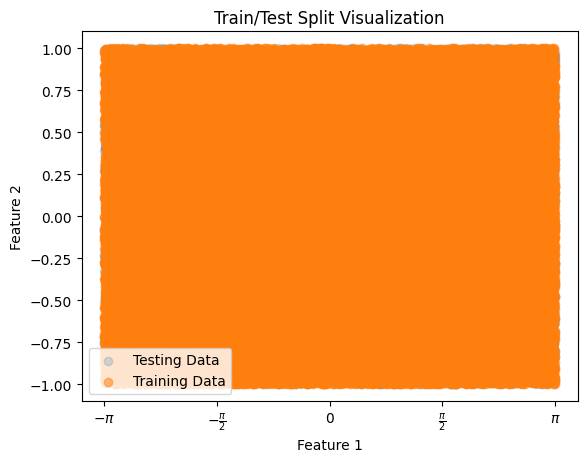

In [ ]:
problem = np.load(os.path.join(DATA_DIR, "problem_0.npz"))
x = problem["x"]
y = problem["y"]
print(x.shape)

x_train, x_test, y_train, y_test = train_test_split(
    x.T, y, test_size=0.25, random_state=42
)

x_train = x_train.T
x_test = x_test.T
print(x_train.shape, x_test.shape)

# Plot testing data
plt.scatter(x_test[0], x_test[1], label="Testing Data", alpha=0.2)

# Plot training data
plt.scatter(x_train[0], x_train[1], label="Training Data", alpha=0.5)


plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Train/Test Split Visualization")


# Define x-axis ticks at multiples of π/2
xticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]

# Set x-axis ticks
plt.xticks(xticks, [r"$-\pi$", r"$-\frac{\pi}{2}$", "0", r"$\frac{\pi}{2}$", r"$\pi$"])

# Show the plot
plt.show()


In [7]:
function_set: list[str] = [
    "add",
    "sub",
    "mul",
    "div",
    "sqrt",
    "log",
    "abs",
    "neg",
    "inv",
    "max",
    "min",
    "sin",
    "cos",
    "tan",
]

sr = SymbolicRegressor(
    metric="rmse", verbose=1, n_jobs=-1, generations=1, function_set=function_set
)
sr.fit(x_train.T, y_train)
print(sr._program)
y_pred_test = sr.predict(x_test.T)
print(
    f"MSE (validation): {100 * np.square(y_test - y_pred_test).sum() / len(y_test):g}"
)


dot_data = sr._program.export_graphviz()
graph = graphviz.Source(dot_data)
display(graph)

mse_val = 100 * np.square(y_test - y_pred_test).sum() / len(y_test)

predicted_program = f"{sr._program}".lower()
create_predicted_function(predicted_program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     7.29          4.45781       11         0.384891              N/A      0.00s
add(mul(div(X17430, X47571), sqrt(X97368)), log(sub(X2415, X26526)))


ValueError: Found array with 0 sample(s) (shape=(0, 100000)) while a minimum of 1 is required.